<a href="https://colab.research.google.com/github/OJB-Quantum/Qiskit-Metal-to-Litho/blob/main/Qiskit_Metal_Fully_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Headless preflight (Qt off) + deps
import os
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.environ["MPLBACKEND"] = "Agg"

import matplotlib as mpl
try:
    mpl.use("Agg", force=True)
except TypeError:
    mpl.use("Agg")
print("Matplotlib backend:", mpl.get_backend())

# Scientific + GDS toolchain (incl. Descartes)
!pip install "jedi>=0.16"
%pip -q install --upgrade pip wheel setuptools
%pip -q install "numpy>=1.24" "matplotlib>=3.8" \
                "gdstk>=0.9.61" "shapely>=2.0" "ezdxf>=1.2.0" \
                "pandas>=2.0" "scipy>=1.10" "networkx>=2.8" \
                "pint>=0.20" "addict>=2.4.0" "pyyaml>=6.0.1" \
                "qutip>=4.7" "h5py>=3.8" "descartes>=1.1" "jedi>=0.19.1"

Matplotlib backend: Agg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.1 MB/s eta 0:00:00


In [2]:
#@title Clone Metal; bind to /content/qiskit-metal; headless, layout-only init (Dict + is_component)
# pylint: disable=invalid-name
import os, sys, re, textwrap
from pathlib import Path

# Fresh clone
!rm -rf /content/qiskit-metal
!git clone --depth 1 https://github.com/qiskit-community/qiskit-metal /content/qiskit-metal

root = Path("/content/qiskit-metal")
pkg  = root / "qiskit_metal"
assert pkg.exists(), f"Package folder missing: {pkg}"

# Force Python to import FROM THIS FOLDER (no editable install)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
os.environ["PYTHONPATH"] = str(root) + (":" + os.environ.get("PYTHONPATH",""))

# --- Replace qiskit_metal/__init__.py with a minimal but compatible headless init ---
orig_init = (pkg / "__init__.py").read_text(encoding="utf-8")
(pkg / "__init__orig.py").write_text(orig_init, encoding="utf-8")

minimal_init = textwrap.dedent("""
    # [colab] Headless, layout-only __init__ (no GUI, no analyses), keep essentials.
    import logging as _logging
    try:
        from addict import Dict as Dict
    except Exception:
        from .toolbox_python.attr_dict import Dict

    logger = _logging.getLogger("qiskit_metal_colab")

    class _Config:
        @staticmethod
        def is_building_docs():
            return False
    config = _Config()

    def is_design(obj):
        try:
            from .designs.design_base import QDesign
            return isinstance(obj, QDesign)
        except Exception:
            return False

    def is_component(obj):
        try:
            from .qlibrary.core.base import QComponent
            return isinstance(obj, QComponent)
        except Exception:
            return False

    __all__ = ["Dict", "config", "logger", "is_design", "is_component"]
""").strip()+"\n"
(pkg / "__init__.py").write_text(minimal_init, encoding="utf-8")

# --- Scrub ALL draw.mpl imports to avoid PySide2 at import time ---
draw_init = pkg / "draw" / "__init__.py"
if draw_init.exists():
    d = draw_init.read_text(encoding="utf-8")
    # Guard "from . import mpl"
    d = re.sub(r'^\s*from\s+\.\s*import\s+mpl\s*$',
               "try:\n    from . import mpl\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl disabled (headless):', _e)\n",
               d, flags=re.MULTILINE)
    # Guard "from .mpl import ..." and any other .mpl imports
    d = re.sub(r'^\s*from\s+\.\s*mpl\s+import[^\n]*$',
               "try:\n    from .mpl import render, figure_spawn\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl (named) disabled (headless):', _e)\n"
               "    def render(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n"
               "    def figure_spawn(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n",
               d, flags=re.MULTILINE)
    draw_init.write_text(d, encoding="utf-8")

# Optional: ensure renderers package never drags Qt; keep explicit imports only
rndr_init = pkg / "renderers" / "__init__.py"
if rndr_init.exists():
    (rndr_init.parent / "__init__orig.py").write_text(rndr_init.read_text(encoding="utf-8"), encoding="utf-8")
    rndr_init.write_text("# [colab] minimal renderers package (explicit imports only; no Qt/MPL)\n__all__ = []\n",
                         encoding="utf-8")

# Verify: import the package *from this folder* and keep it light
import importlib, sys as _sys
importlib.invalidate_caches()
import qiskit_metal
print("qiskit_metal from:", qiskit_metal.__file__)
assert qiskit_metal.__file__.startswith(str(pkg)), "Not importing from /content/qiskit-metal!"


Cloning into '/content/qiskit-metal'...
remote: Enumerating objects: 1050, done.
remote: Counting objects: 100% (1050/1050), done.
remote: Compressing objects: 100% (952/952), done.
remote: Total 1050 (delta 166), reused 673 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (1050/1050), 30.22 MiB | 13.23 MiB/s, done.
Resolving deltas: 100% (166/166), done.
Updating files: 100% (1101/1101), done.
qiskit_metal from: /content/qiskit-metal/qiskit_metal/__init__.py


In [33]:
# -*- coding: utf-8 -*-
# Layout-only GDS export using GDSTK with unit auto-detect (mm vs m) from Qiskit Metal tables.
import os, warnings
os.environ["QT_QPA_PLATFORM"] = "offscreen"

# --- deps ---
try:
    import gdstk  # type: ignore
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gdstk>=0.9.5"])
    import gdstk

# Shapely (buffer with round joins/caps)
try:
    from shapely.geometry import Polygon as ShpPolygon, LineString as ShpLineString, MultiPolygon as ShpMultiPolygon
    try:
        # Shapely >= 1.8 / 2.x
        from shapely.geometry import CAP_STYLE, JOIN_STYLE
        CAP_ROUND, JOIN_ROUND = CAP_STYLE.round, JOIN_STYLE.round
    except Exception:
        # Fallback numeric constants (older Shapely): round=1, mitre=2, bevel=3
        CAP_ROUND, JOIN_ROUND = 1, 1
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "shapely>=1.8"])
    from shapely.geometry import Polygon as ShpPolygon, LineString as ShpLineString, MultiPolygon as ShpMultiPolygon
    from shapely.geometry import CAP_STYLE, JOIN_STYLE
    CAP_ROUND, JOIN_ROUND = CAP_STYLE.round, JOIN_STYLE.round

from qiskit_metal.designs import DesignPlanar
from qiskit_metal.toolbox_python.attr_dict import Dict
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.sample_shapes.rectangle import Rectangle

# -----------------------------
# CONTROL KNOBS
# -----------------------------
CPW_WIDTH_UM       = 10.0
CPW_GAP_UM         = 6.0

# Treat as *extra* length injected by meanders (not the total straight run).
MEANDER_EXTRA_UM   = 3000.0
MEANDER_SP_UM      = 600.0         # practical default for multiple U/∩ turns
FILLET_UM          = 60.0          # clipped below to fit spacing

LEAD_START_UM      = 300.0
LEAD_END_UM        = 300.0

# Launch pads
PAD_WIDTH_UM       = 300.0
TAPER_HEIGHT_UM    = 300.0
PAD_HEIGHT_UM      = 240.0
PAD_GAP_UM         = 144.0
LEAD_LEN_UM        = 50.0

# Pad locations (collinear along +x)
LP_LEFT_X_UM       = 0.0
LP_RIGHT_X_UM      = 4500.0
LP_Y_UM            = 0.0

# Chip size (string units understood by Qiskit Metal)
CHIP_SIZE_X        = "8mm"
CHIP_SIZE_Y        = "4mm"

# Centering & cutouts
SKIP_HELPERS           = True      # ignore helper entries from qgeometry
ADD_EXPLICIT_GROUND    = True      # just a helper inside qgeometry; export uses gdstk ground
EXPLICIT_GROUND_HELPER = True

# IMPORTANT: remove the big square hole (moat)
ADD_MOAT_KEEP_OUT      = False     # <- turn OFF to delete the large subtract rectangle
MOAT_W_UM              = 4800.0
MOAT_H_UM              = 1000.0
MOAT_CX_UM             = 0.0
MOAT_CY_UM             = 0.0

# GDS output
GDS_OUT        = "/content/meander_with_ground_gdstk.gds"
GDS_TOP_CELL   = "TOP"
GDS_UNIT       = 1e-6   # GDS unit = 1 µm
GDS_PRECISION  = 1e-9   # 1 nm grid

# Layers
LAYER_METAL    = 1
LAYER_GROUND   = 2
DT             = 0

# -----------------------------
# Build Qiskit Metal design (headless)
# -----------------------------
design = DesignPlanar(metadata={}, overwrite_enabled=True, enable_renderers=False)
design.variables["cpw_width"] = f"{CPW_WIDTH_UM}um"
design.variables["cpw_gap"]   = f"{CPW_GAP_UM}um"
design.chips.main.size["size_x"] = CHIP_SIZE_X
design.chips.main.size["size_y"] = CHIP_SIZE_Y

lpL = LaunchpadWirebond(design, "LP_left", options=dict(
    pos_x=f"{LP_LEFT_X_UM}um", pos_y=f"{LP_Y_UM}um", orientation="0",
    trace_width=f"{CPW_WIDTH_UM}um", trace_gap=f"{CPW_GAP_UM}um",
    lead_length=f"{LEAD_LEN_UM}um",
    pad_width=f"{PAD_WIDTH_UM}um", pad_height=f"{PAD_HEIGHT_UM}um",
    pad_gap=f"{PAD_GAP_UM}um", taper_height=f"{TAPER_HEIGHT_UM}um"
))
lpR = LaunchpadWirebond(design, "LP_right", options=dict(
    pos_x=f"{LP_RIGHT_X_UM}um", pos_y=f"{LP_Y_UM}um", orientation="180",
    trace_width=f"{CPW_WIDTH_UM}um", trace_gap=f"{CPW_GAP_UM}um",
    lead_length=f"{LEAD_LEN_UM}um",
    pad_width=f"{PAD_WIDTH_UM}um", pad_height=f"{PAD_HEIGHT_UM}um",
    pad_gap=f"{PAD_GAP_UM}um", taper_height=f"{TAPER_HEIGHT_UM}um"
))

# ---- Force meanders: total_length = straight base + extra meander length ----
DX_UM        = abs(LP_RIGHT_X_UM - LP_LEFT_X_UM)
L_BASE_UM    = DX_UM + LEAD_START_UM + LEAD_END_UM
TOTAL_LEN_UM = L_BASE_UM + MEANDER_EXTRA_UM

# Clip fillet so it fits the lane: R <= 0.5*spacing - 0.5*width
R_MAX         = max(1.0, 0.5 * MEANDER_SP_UM - 0.5 * CPW_WIDTH_UM)
FILLET_EFF_UM = min(FILLET_UM, R_MAX)

BUS_NAME = "meander_L2R"
meander_opts = Dict(
    pin_inputs=Dict(
        start_pin=Dict(component=lpL.name, pin="tie"),
        end_pin=Dict(component=lpR.name, pin="tie")
    ),
    total_length=f"{TOTAL_LEN_UM}um",
    fillet=f"{FILLET_EFF_UM}um",
    meander=Dict(spacing=f"{MEANDER_SP_UM}um", asymmetry="0um"),
    prevent_short_edges=True,
    snap=True,
    lead=Dict(start_straight=f"{LEAD_START_UM}um", end_straight=f"{LEAD_END_UM}um"),
)
bus = RouteMeander(design, BUS_NAME, options=meander_opts)
bus.rebuild()

# -----------------------------
# Tables
# -----------------------------
ptab = design.qgeometry.tables.get("path")
polytab = design.qgeometry.tables.get("poly")

# -----------------------------
# Unit auto-detect (mm vs m) -> scale to µm
# -----------------------------
def _detect_scale_to_um(ptab) -> float:
    if ptab is None or "width" not in ptab.columns or len(ptab) == 0:
        return 1.0
    try:
        w_tbl = float(ptab.iloc[0]["width"])
    except Exception:
        return 1.0
    if 1e-3 <= w_tbl <= 5e-2:   # mm-ish (e.g., 0.010 for 10 µm)
        return 1000.0           # mm → µm
    if 1e-7 <= w_tbl <= 1e-3:   # meters-ish
        return 1e6              # m → µm
    return 1.0                  # already µm

S_TO_UM = _detect_scale_to_um(ptab)

# -----------------------------
# Helpers: shapely → list of polygons (µm coords)
# -----------------------------
def _as_polygons_um(geom):
    polys = []
    if geom is None:
        return polys
    if isinstance(geom, ShpPolygon):
        seq = [(geom.exterior, list(geom.interiors))]
    elif isinstance(geom, ShpMultiPolygon):
        seq = [(p.exterior, list(p.interiors)) for p in geom.geoms]
    else:
        raise TypeError(f"Unsupported geometry type: {type(geom)}")
    for ext, holes in seq:
        outer = [(x * S_TO_UM, y * S_TO_UM) for (x, y) in ext.coords]
        hole_list = [[(x * S_TO_UM, y * S_TO_UM) for (x, y) in h.coords] for h in holes]
        polys.append((outer, hole_list))
    return polys

def _rounded_buffer(line: ShpLineString, dist: float, segs: int = 48):
    """Round buffer preserves fillets (Shapely 1.8/2.x compatible)."""
    try:
        # Shapely 2.x signature
        return line.buffer(dist, quad_segs=segs, cap_style=CAP_ROUND, join_style=JOIN_ROUND)
    except TypeError:
        # Shapely 1.8 signature
        return line.buffer(dist, resolution=segs, cap_style=CAP_ROUND, join_style=JOIN_ROUND)

def _path_to_polygon(geom_line, width_in_table_units, segs: int = 48):
    if not isinstance(geom_line, ShpLineString):
        raise TypeError("Expected shapely LineString.")
    poly = _rounded_buffer(geom_line, width_in_table_units / 2.0, segs=segs)
    return _as_polygons_um(poly)

def _mm_or_um_to_um(s):
    t = str(s).strip().lower()
    if t.endswith("mm"):
        return float(t[:-2]) * 1000.0
    if t.endswith("um"):
        return float(t[:-2])
    return float(t)

# -----------------------------
# Compose buckets (skip helpers; remove moat if disabled)
# -----------------------------
metal_by_layer = {}
cuts_by_layer  = {}

# PATH table
if ptab is not None and len(ptab):
    for _, row in ptab.iterrows():
        if SKIP_HELPERS and bool(row.get("helper", False)):
            continue
        lyr = int(row.get("layer", LAYER_METAL))
        subtract = bool(row.get("subtract", False))
        geom = row.get("geometry", None)
        width_native = float(row.get("width", 0.0))
        polys = _path_to_polygon(geom, width_in_table_units=width_native, segs=48) \
                if isinstance(geom, ShpLineString) else _as_polygons_um(geom)
        (cuts_by_layer if subtract else metal_by_layer).setdefault(lyr, []).extend(polys)

# POLY table
if polytab is not None and len(polytab):
    for _, row in polytab.iterrows():
        name = str(row.get("component", "") or row.get("name", ""))
        if ADD_MOAT_KEEP_OUT is False and name == "MeanderMoat":
            # drop moat to remove the big square hole
            continue
        if SKIP_HELPERS and bool(row.get("helper", False)):
            continue
        lyr = int(row.get("layer", LAYER_METAL))
        subtract = bool(row.get("subtract", False))
        geom = row.get("geometry", None)
        polys = _as_polygons_um(geom)
        (cuts_by_layer if subtract else metal_by_layer).setdefault(lyr, []).extend(polys)

# -----------------------------
# Compute metal bbox center, translate everything to center at origin
# -----------------------------
def _bucket_bbox(bucket):
    import math
    minx = miny = math.inf
    maxx = maxy = -math.inf
    for plist in bucket.values():
        for outer, _holes in plist:
            if not outer:
                continue
            xs, ys = zip(*outer)
            minx = min(minx, min(xs)); maxx = max(maxx, max(xs))
            miny = min(miny, min(ys)); maxy = max(maxy, max(ys))
    return (minx, miny, maxx, maxy)

def _shift_bucket(bucket, dx, dy):
    for lyr, plist in list(bucket.items()):
        for i, (outer, holes) in enumerate(plist):
            outer2 = [(x - dx, y - dy) for (x, y) in outer]
            holes2 = [[(x - dx, y - dy) for (x, y) in h] for h in holes]
            plist[i] = (outer2, holes2)
        bucket[lyr] = plist

# BBox from METAL only (pads + meander) for centering
import math
if metal_by_layer:
    minx, miny, maxx, maxy = _bucket_bbox(metal_by_layer)
    if all(map(math.isfinite, (minx, miny, maxx, maxy))) and (maxx > minx) and (maxy > miny):
        cx_um = 0.5 * (minx + maxx)
        cy_um = 0.5 * (miny + maxy)
        # Shift both metal and cuts so center → (0,0)
        _shift_bucket(metal_by_layer, cx_um, cy_um)
        _shift_bucket(cuts_by_layer,  cx_um, cy_um)
        print(f"[center] Translated geometry by (-{cx_um:.3f}, -{cy_um:.3f}) µm to center at origin.")
    else:
        cx_um = cy_um = 0.0
        print("[center] Could not compute bbox; leaving at origin.")
else:
    cx_um = cy_um = 0.0
    print("[center] No metal polygons found; leaving at origin.")

# -----------------------------
# GDSTK library/cell
# -----------------------------
lib = gdstk.Library(unit=GDS_UNIT, precision=GDS_PRECISION)
top = lib.new_cell(GDS_TOP_CELL)

# Ground rectangle (µm coords), now centered at origin
sx_um = _mm_or_um_to_um(design.chips.main.size["size_x"])
sy_um = _mm_or_um_to_um(design.chips.main.size["size_y"])
chip_rect = gdstk.rectangle((-sx_um/2, -sy_um/2), (sx_um/2, sy_um/2), layer=LAYER_GROUND, datatype=DT)

# Union of all cuts (from BOTH tables), then subtract from ground
all_cuts = [gdstk.Polygon(outer, layer=LAYER_GROUND, datatype=DT)
            for _, plist in cuts_by_layer.items()
            for (outer, _holes) in plist]

if all_cuts:
    # Union then difference; nm-scale precision stabilizes clipping
    cuts_union = gdstk.boolean(all_cuts, [], "or", precision=5e-3, layer=LAYER_GROUND, datatype=DT)
    ground_effective = gdstk.boolean([chip_rect], cuts_union, "not", precision=5e-3, layer=LAYER_GROUND, datatype=DT)
else:
    ground_effective = [chip_rect]

# Draw order: ground first, then metal on top
for g in ground_effective or []:
    top.add(gdstk.Polygon(g.points, layer=LAYER_GROUND, datatype=DT))

for lyr, plist in metal_by_layer.items():
    for outer, holes in plist:
        if holes:
            outer_poly = gdstk.Polygon(outer, layer=lyr, datatype=DT)
            holes_union = gdstk.boolean([gdstk.Polygon(h, layer=lyr) for h in holes], [], "or",
                                        precision=5e-3, layer=lyr, datatype=DT)
            res = gdstk.boolean([outer_poly], holes_union, "not", precision=5e-3, layer=lyr, datatype=DT)
            for r in (res or []):
                top.add(r)
        else:
            top.add(gdstk.Polygon(outer, layer=lyr, datatype=DT))

lib.write_gds(GDS_OUT)
print(f"[OK] GDS written (units fixed) → {GDS_OUT}")

warnings.filterwarnings("ignore", message=r"The behavior of DataFrame concatenation .* is deprecated")


[center] Translated geometry by (-2250.000, -0.000) µm to center at origin.
[OK] GDS written (units fixed) → /content/meander_with_ground_gdstk.gds


[load] Reading: /content/meander_with_ground_gdstk.gds
[info] Using requested cell: TOP
[info] Bounds (µm): x[-4000.000, 4000.000], y[-2000.000, 2000.000]
[ok] wrote PNG: /content/meander_with_ground_gdstk_preview_600dpi.png
[ok] wrote PDF: /content/meander_with_ground_gdstk_preview.pdf


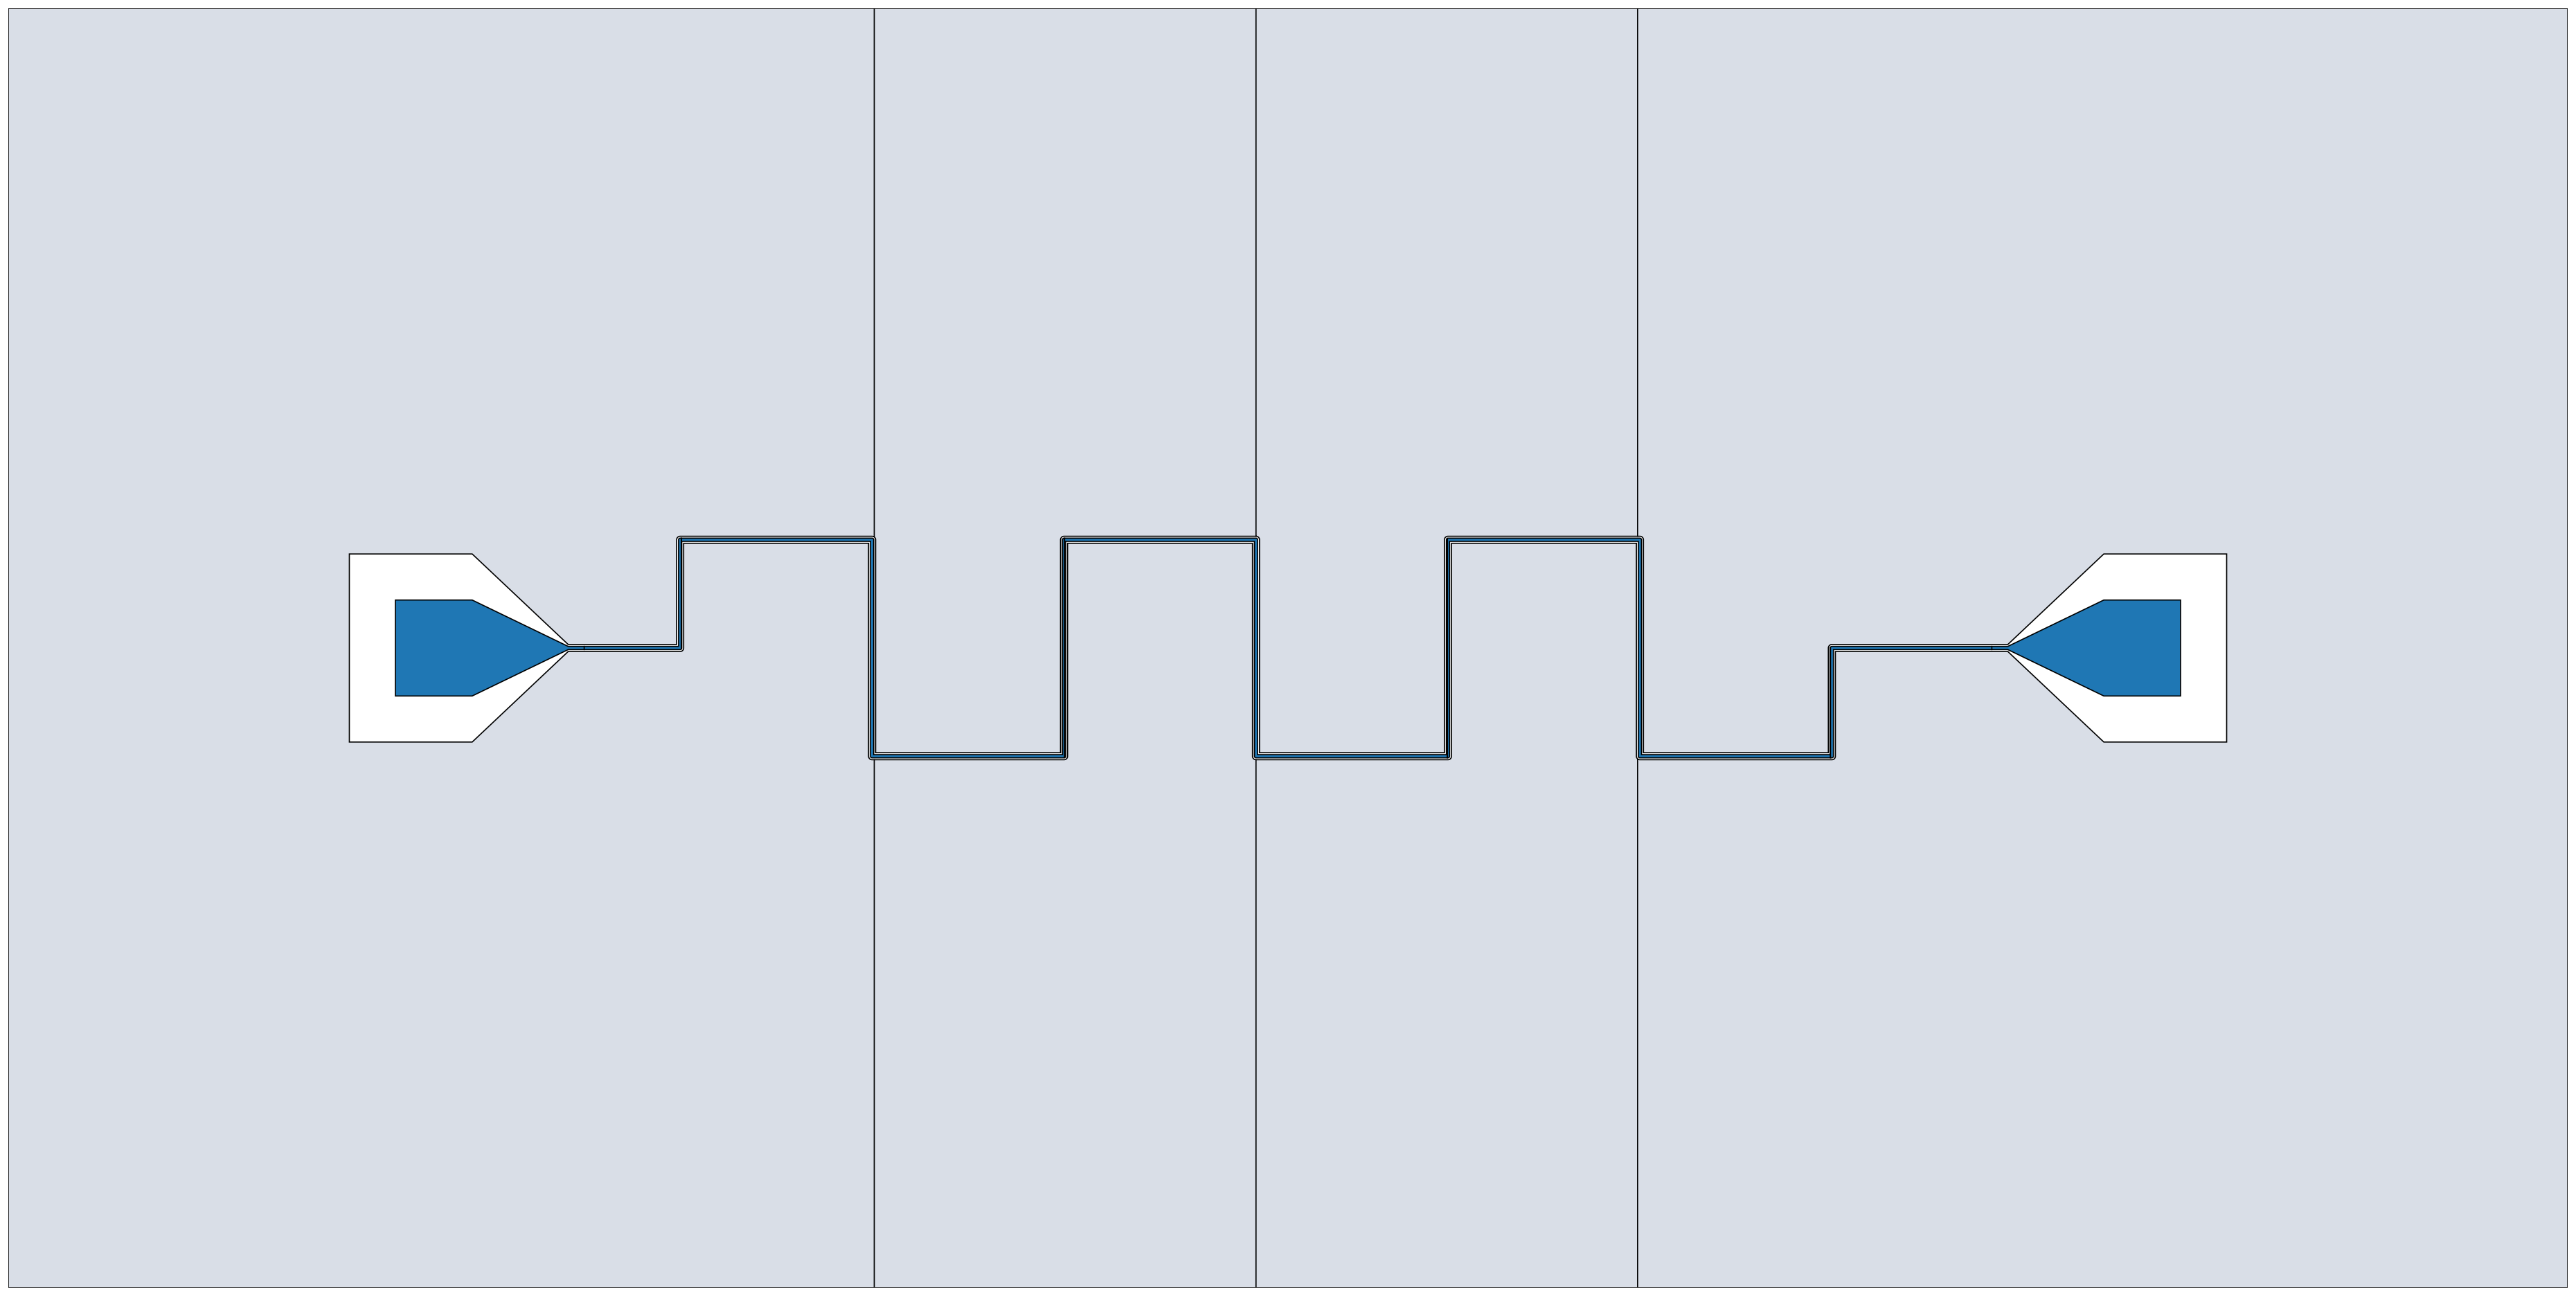

In [34]:
#@title Preview GDS inline *and* save 600-DPI PNG + a vector PDF
import os, glob, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from IPython.display import display, Image
import gdstk

# ----- knobs you can tweak -----
GDS_PATH      = globals().get("GDS_OUT", "/content/meander_with_ground_gdstk.gds")  # reuse if set
TOP_CELL_NAME = globals().get("GDS_TOP_CELL", None)                                  # reuse if set
DPI           = 600
FIG_WIDTH_IN  = 8.0
LINEWIDTH_PT  = 0.20
BG_COLOR      = "white"

# Layer colors (extend as needed)
LAYER_GROUND  = 2
LAYER_METAL   = 1
LAYER_COLOR   = {LAYER_GROUND: "#d9dee7", LAYER_METAL: "#1f77b4"}

def _pick_cell(lib, name=None):
    if name and name in [c.name for c in lib.cells]:
        print(f"[info] Using requested cell: {name}")
        return lib[name]
    tops = lib.top_level()
    if not tops:
        raise RuntimeError("No top-level cells in library.")
    print(f"[info] Auto-picked top cell: {tops[0].name}")
    return tops[0]

def _polys_by_layer(cell):
    # include_paths=True expands PATHs to polygons; apply_repetitions=True follows array/repetition
    polys = cell.get_polygons(apply_repetitions=True, include_paths=True, depth=None)
    by_layer, xs, ys = {}, [], []
    for p in polys:  # gdstk.Polygon objects
        layer = int(getattr(p, "layer", 0))
        pts = np.asarray(p.points, dtype=float)
        by_layer.setdefault(layer, []).append(pts)
        xs.append(pts[:, 0]); ys.append(pts[:, 1])
    if not xs:
        raise RuntimeError("Found no polygons to plot (empty cell?).")
    xs = np.concatenate(xs); ys = np.concatenate(ys)
    return by_layer, (float(xs.min()), float(ys.min()), float(xs.max()), float(ys.max()))

def save_and_show(gds_path, top_cell_name=None, dpi=DPI, fig_w_in=FIG_WIDTH_IN, lw_pt=LINEWIDTH_PT):
    if not os.path.exists(gds_path):
        # try last written .gds in /content
        cand = sorted(glob.glob("/content/*.gds"), key=os.path.getmtime)[-1:] or []
        if not cand:
            raise FileNotFoundError(f"GDS not found: {gds_path}")
        print(f"[warn] {gds_path} not found. Using most recent: {cand[0]}")
        gds_path = cand[0]

    print(f"[load] Reading: {gds_path}")
    lib  = gdstk.read_gds(gds_path)                                   # loads the library
    cell = _pick_cell(lib, top_cell_name)                              # choose cell
    by_layer, (minx, miny, maxx, maxy) = _polys_by_layer(cell)         # collect polys + bounds
    print(f"[info] Bounds (µm): x[{minx:.3f}, {maxx:.3f}], y[{miny:.3f}, {maxy:.3f}]")

    w_um = maxx - minx; h_um = maxy - miny
    aspect = w_um / max(h_um, 1e-12); fig_h_in = fig_w_in / aspect

    fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in), dpi=dpi)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    ax.set_facecolor(BG_COLOR); ax.axis("off")

    # Draw ground first, then metal, then others for determinism
    draw_order = sorted(by_layer.keys(), key=lambda L: (L != LAYER_GROUND, L))
    for layer in draw_order:
        face = LAYER_COLOR.get(layer, "#666666")
        for pts in by_layer[layer]:
            ax.add_patch(MplPolygon(pts, closed=True, facecolor=face, edgecolor="black",
                                    linewidth=lw_pt, antialiased=True))

    root, _ = os.path.splitext(gds_path)
    out_png = f"{root}_preview_{dpi}dpi.png"
    out_pdf = f"{root}_preview.pdf"

    # Ensure renderer computes extents before saving
    fig.canvas.draw()
    fig.savefig(out_png, dpi=dpi, bbox_inches="tight", pad_inches=0.02)  # 600-DPI PNG
    fig.savefig(out_pdf,            bbox_inches="tight", pad_inches=0.02)  # vector PDF
    print(f"[ok] wrote PNG: {out_png}")
    print(f"[ok] wrote PDF: {out_pdf}")

    # Show inline in the notebook (forces frontend display)
    display(Image(filename=out_png))
    return out_png, out_pdf

png_path, pdf_path = save_and_show(GDS_PATH, top_cell_name=TOP_CELL_NAME)
